# Dog Project Work Book

#### Brief Overview of Work Book

#### Import Statements

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing import image                  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

import sklearn
from sklearn.datasets import load_files       
import numpy as np
from glob import glob
import random
import matplotlib.pyplot as plt                        
%matplotlib inline

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint  

Using TensorFlow backend.


## Organize the Data
The data needs to be organized so that it can be easily input into different models.

### Datasets

#### Dog/Human Data
This will be used to train the Dog/Human detectors.

In [2]:
# Collect all Dog Data
dog_data = np.expand_dims(np.array(glob('dogImages/*/*/*')), axis=1)
np.random.shuffle(dog_data)

# Collect all Human Data
human_data = np.expand_dims(np.array(glob('lfw/*/*')), axis=1)
np.random.shuffle(human_data)

# We want equal data from dog and human categories so we only use some of the human data
human_data = human_data[:dog_data.shape[0]]

So the data has been put in the numpy arrays and shuffled. The next step is to:
<ol>
    <li>Assign Labels</li>
    <li>Combine the Arrays</li>
    <li>Reshuffle the Data</li>
</ol>

In [3]:
# Assign labels to data; 1 for Human 0, for Dog
human_labels = np.ones(human_data.shape, dtype=np.float32)
dog_labels = np.zeros(dog_data.shape, dtype=np.float32)

# Combine labels with respective data, combine all data into one array
labeled_human_data = np.concatenate((human_data, human_labels), axis=1)
labeled_dog_data = np.concatenate((dog_data, dog_labels), axis=1)
detector_data = np.concatenate((labeled_human_data, labeled_dog_data), axis=0)

# Shuffled data for detector
np.random.shuffle(detector_data)

# Split into input and labels
detector_inputs = detector_data[:,0]
human_det_labels = detector_data[:,1].astype(np.float32)

# Flip labels for dog detector
dog_det_labels = 1 - human_det_labels

The next cell shows that the first 10 entries and the labels make sense

In [4]:
for item in zip(detector_inputs[:10], human_det_labels, dog_det_labels):
    print('Filename:', item[0], '     Human Label:', item[1], '     Dog Label:', item[2])

Filename: dogImages\train\069.French_bulldog\French_bulldog_04767.jpg      Human Label: 0.0      Dog Label: 1.0
Filename: dogImages\train\130.Welsh_springer_spaniel\Welsh_springer_spaniel_08218.jpg      Human Label: 0.0      Dog Label: 1.0
Filename: lfw\Elizabeth_Hurley\Elizabeth_Hurley_0005.jpg      Human Label: 1.0      Dog Label: 0.0
Filename: dogImages\train\090.Italian_greyhound\Italian_greyhound_06150.jpg      Human Label: 0.0      Dog Label: 1.0
Filename: dogImages\train\086.Irish_setter\Irish_setter_05870.jpg      Human Label: 0.0      Dog Label: 1.0
Filename: dogImages\train\107.Norfolk_terrier\Norfolk_terrier_07066.jpg      Human Label: 0.0      Dog Label: 1.0
Filename: lfw\Abdullatif_Sener\Abdullatif_Sener_0002.jpg      Human Label: 1.0      Dog Label: 0.0
Filename: lfw\Osmond_Smith\Osmond_Smith_0001.jpg      Human Label: 1.0      Dog Label: 0.0
Filename: lfw\Pervez_Musharraf\Pervez_Musharraf_0012.jpg      Human Label: 1.0      Dog Label: 0.0
Filename: lfw\Walter_Mondale\Wal

Finally, the data needs to be split into training, validation, and test sets.

In [5]:
detector_inputs.shape

(16702,)

In [6]:
# we want 2000 validation and 1000 test examples
test_index = (0, 1000)
validation_index = (1000, 3000)
train_index = (3000, 16701)

def get_data(inputs, labels, indices):
    '''
        function desc.
        
        Inputs:
        
        Returns:
    '''
    input_data = inputs[indices[0]: indices[1]]
    data_labels = labels[indices[0]: indices[1]]
    return input_data, data_labels

hd_train_items, hd_train_labels = get_data(detector_inputs, human_det_labels, train_index)
hd_valid_items, hd_valid_labels = get_data(detector_inputs, human_det_labels, validation_index)
hd_test_items, hd_test_labels = get_data(detector_inputs, human_det_labels, test_index)

dd_train_items, dd_train_labels = get_data(detector_inputs, dog_det_labels, train_index)
dd_valid_items, dd_test_labels = get_data(detector_inputs, dog_det_labels, validation_index)
dd_test_items, dd_test_labels = get_data(detector_inputs, dog_det_labels, test_index)

In [7]:
for item in zip(dd_train_items[:10], dd_train_labels[:10]):
    print(item)

('dogImages\\train\\099.Lhasa_apso\\Lhasa_apso_06643.jpg', 1.0)
('dogImages\\train\\012.Australian_shepherd\\Australian_shepherd_00825.jpg', 1.0)
('dogImages\\test\\070.German_pinscher\\German_pinscher_04861.jpg', 1.0)
('dogImages\\train\\046.Cavalier_king_charles_spaniel\\Cavalier_king_charles_spaniel_03328.jpg', 1.0)
('dogImages\\train\\075.Glen_of_imaal_terrier\\Glen_of_imaal_terrier_05141.jpg', 1.0)
('dogImages\\valid\\101.Maltese\\Maltese_06737.jpg', 1.0)
('lfw\\Nestor_Kirchner\\Nestor_Kirchner_0035.jpg', 0.0)
('lfw\\Richard_Gephardt\\Richard_Gephardt_0001.jpg', 0.0)
('dogImages\\train\\024.Bichon_frise\\Bichon_frise_01772.jpg', 1.0)
('lfw\\Heidi_Fleiss\\Heidi_Fleiss_0003.jpg', 0.0)


#### Dog Breed Data
This will be used to train the breed classifiers.

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    '''
        function desc.
        
        Inputs:
        
        Returns:
    '''
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
breed_train_files, breed_train_labels = load_dataset('dogImages/train')
breed_valid_files, breed_valid_labels = load_dataset('dogImages/valid')
breed_test_files, breed_test_labels = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

#### Convert files to tensors
The data needs to be converted to tensors and formatted to be input into pretrained models.

In [3]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [4]:
# human/dog detector data
hd_train_tensors = paths_to_tensor(hd_train_items).astype('float32')
hd_valid_tensors = paths_to_tensor(hd_valid_items).astype('float32')
hd_test_tensors = paths_to_tensor(hd_test_items).astype('float32')

dd_train_tensors = paths_to_tensor(dd_train_items).astype('float32')
dd_valid_tensors = paths_to_tensor(dd_valid_items).astype('float32')
dd_test_tensors = paths_to_tensor(dd_test_items).astype('float32')

NameError: name 'hd_train_items' is not defined

In [4]:
# breed detector data
breed_train_tensors = paths_to_tensor(breed_train_files).astype('float32')/255
breed_valid_tensors = paths_to_tensor(breed_valid_files).astype('float32')/255
breed_test_tensors = paths_to_tensor(breed_test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:06<00:00, 138.50it/s]


### Data Augmentation

In [26]:
# Undo normalization for other preprocessing
breed_train_tensors *= 255
breed_valid_tensors *= 255
breed_test_tensors *= 255

#### Preprocess Data for Pretrained Models

In [5]:
def imagenet_prep(image_tensors):
    '''
        Takes the image tensors and processes them for the models trained on ImageNet.
        
        Inputs: Image tensor of shape (images, width, height, colorchannels)
        
        Returns: Tensor of same shape with color channels flipped and values centered around zero for each color channel.
    '''
    # imagenet averages for RGB
    image_net_mean = np.array([103.939,116.779,123.68])
    image_tensors -= image_net_mean
    
    # Flip color channels
    image_tensors = image_tensors[:, :, :, ::-1]
    return image_tensors

In [13]:
def unprocess(image_tensors, mode='caffe'):
    '''
        Unprocesses the preprocessing step for imagenet.
    '''
    if mode == 'caffe':
        # Flip color channels
        image_tensors = image_tensors[:, :, :, ::-1]

        # Add RBG mean back to images
        image_net_mean = np.array([103.939,116.779,123.68])
        image_tensors += image_net_mean
        image_tensors = np.clip(image_tensors, 0, 256)
        return image_tensors
    else:
        image_tensors = np.clip((image_tensors + 1)*127.5, 0, 255)
        return image_tensors

#### Create Generator for Augmented Training Data

In [6]:
training_generator = ImageDataGenerator(rescale=1.,
                                        rotation_range=15.0,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=0.1,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=False,
                                        fill_mode="reflect")

validation_generator = ImageDataGenerator(rescale=1)

In [7]:
scratch_data = training_generator.flow(breed_train_tensors, breed_train_labels, batch_size=32)

In [8]:
inception_data = training_generator.flow(breed_train_tensors, breed_train_labels, batch_size=32)

## Human/Dog Detector
Build a model that predicts if there is a dog, human, both or neither in the image.

### Human Detection

In [11]:
train_inputs, train_hlabels = get_data(detector_inputs, human_det_labels, train_index)

In [12]:
train_inputs = paths_to_tensor(train_inputs)

100%|███████████████████████████████████████████████████████████████████████████| 13701/13701 [01:09<00:00, 196.83it/s]


In [17]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [19]:
model = InceptionV3(include_top=False, weights='imagenet')

<tf.Tensor 'mixed10/concat:0' shape=(?, ?, ?, 2048) dtype=float32>

### Dog Detection

### Object Localization

### Split Image for Images Containing Both

## Breed Classifier for Dogs
Build a model to predict the dog breed, optimized for pictures of dogs.

### CNN from Scratch

#### Build Model

Reminder that the data arrays are named:
<ul>
    <li>breed_train_aug, breed_labels_aug</li>
    <li>breed_valid_pp, breed_valid_labels</li>
    <li>breed_test_pp, breed_test_labels</li>
</ul>

In [21]:
model = Sequential()
# Conv layer1
model.add(Conv2D(32, 3, strides=(1,1), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

# Conv layer2
model.add(Conv2D(64, 3, strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

# Conv layer3
model.add(Conv2D(128, 3, strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

# Conv layer4
model.add(Conv2D(256, 3, strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

# Conv layer5
model.add(Conv2D(256, 3, strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2,2), strides= 2, padding='same'))

#Flatten Layer
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())

#Fully Connected Layer 2
model.add(Dense(133, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 256)       295168    
__________

In [22]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#### Train Model

In [23]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_da.hdf5', 
                               verbose=0, save_best_only=True)

model.fit_generator(training_data, steps_per_epoch=len(breed_train_tensors)//32, epochs=epochs,
                    callbacks=[checkpointer], verbose=2, 
                    validation_data=(breed_valid_tensors, breed_valid_labels))

Epoch 1/10
 - 62s - loss: 4.7962 - acc: 0.0170 - val_loss: 4.8083 - val_acc: 0.0156
Epoch 2/10
 - 63s - loss: 4.5329 - acc: 0.0362 - val_loss: 4.8776 - val_acc: 0.0192
Epoch 3/10
 - 64s - loss: 4.3268 - acc: 0.0527 - val_loss: 5.1107 - val_acc: 0.0240
Epoch 4/10
 - 61s - loss: 4.1206 - acc: 0.0765 - val_loss: 4.5218 - val_acc: 0.0563
Epoch 5/10
 - 57s - loss: 3.8856 - acc: 0.1103 - val_loss: 4.3029 - val_acc: 0.0802
Epoch 6/10
 - 57s - loss: 3.6471 - acc: 0.1379 - val_loss: 3.8123 - val_acc: 0.1473
Epoch 7/10
 - 57s - loss: 3.4408 - acc: 0.1789 - val_loss: 3.9841 - val_acc: 0.1162
Epoch 8/10
 - 57s - loss: 3.2625 - acc: 0.2068 - val_loss: 3.5572 - val_acc: 0.1653
Epoch 9/10
 - 60s - loss: 3.0460 - acc: 0.2469 - val_loss: 3.3618 - val_acc: 0.2072
Epoch 10/10
 - 60s - loss: 2.8351 - acc: 0.2874 - val_loss: 3.2156 - val_acc: 0.2156


### Build Classifier using a pretrained model

#### Compute Bottleneck Features

In [57]:
from keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(include_top=False, weights='imagenet')

In [58]:
new_bottleneck = inception.predict(breed_train_tensors)

In [15]:
new_valid = inception.predict(breed_valid_tensors)

In [16]:
### TODO: Define your architecture.

inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=new_bottleneck.shape[1:]))
inception_model.add(BatchNormalization())

inception_model.add(Dense(500, activation='relu'))
inception_model.add(BatchNormalization())
inception_model.add(Dropout(.2))

inception_model.add(Dense(500, activation='relu'))
inception_model.add(BatchNormalization())
inception_model.add(Dropout(.2))

inception_model.add(Dense(133, activation='softmax'))
inception_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception.hdf5', 
                               verbose=0, save_best_only=True)

inception_model.fit(new_bottleneck, breed_train_labels, 
          validation_data=(new_valid, breed_valid_labels),
          epochs=50, batch_size=32, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
 - 7s - loss: 1.3206 - acc: 0.6732 - val_loss: 0.6862 - val_acc: 0.8132
Epoch 2/50
 - 4s - loss: 0.5820 - acc: 0.8229 - val_loss: 0.6441 - val_acc: 0.8383
Epoch 3/50
 - 3s - loss: 0.4117 - acc: 0.8675 - val_loss: 0.6631 - val_acc: 0.8216
Epoch 4/50
 - 4s - loss: 0.3132 - acc: 0.8990 - val_loss: 0.7470 - val_acc: 0.8228
Epoch 5/50
 - 4s - loss: 0.2646 - acc: 0.9141 - val_loss: 0.6859 - val_acc: 0.8311
Epoch 6/50
 - 3s - loss: 0.2162 - acc: 0.9290 - val_loss: 0.7047 - val_acc: 0.8323
Epoch 7/50
 - 3s - loss: 0.1713 - acc: 0.9458 - val_loss: 0.7077 - val_acc: 0.8299
Epoch 8/50


KeyboardInterrupt: 

In [128]:
base_model = InceptionV3(include_top=False, weights='imagenet')

In [129]:
pre_training = base_model.predict(breed_train_tensors)

In [125]:
post_training = base_model.predict(breed_train_tensors)

In [122]:
base_model.trainable=False
for layer in base_model.layers:
    layer.trainable=False

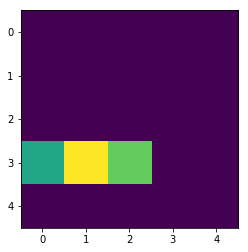

In [130]:
plt.imshow(pre_training[0][:,:,0])

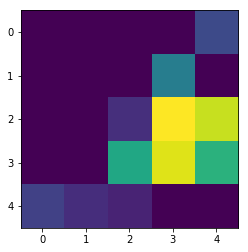

In [127]:
plt.imshow(post_training[0][:,:,0])

In [123]:
x = base_model.output
model2 = GlobalAveragePooling2D()(x)
model2 = BatchNormalization()(model2)

model2 = Dense(500, activation='relu')(model2)
model2 = BatchNormalization()(model2)
model2 = Dropout(.2)(model2)

model2 = Dense(500, activation='relu')(model2)
model2 = BatchNormalization()(model2)
model2 = Dropout(.2)(model2)

model2 = Dense(133, activation='softmax')(model2)
model = Model(inputs=base_model.input, outputs=model2)

for layer in model.layers:
    layer.trainable=False
for layer in model.layers[311:]:
    layer.trainable=True

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [124]:
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception.hdf5', 
                               verbose=0, save_best_only=True)

model.fit(breed_train_tensors, breed_train_labels, 
          validation_data=(breed_valid_tensors, breed_valid_labels),
          epochs=10, batch_size=32, callbacks=[checkpointer], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
 - 160s - loss: 2.5018 - acc: 0.4238 - val_loss: 1.3210 - val_acc: 0.6323
Epoch 2/10
 - 34s - loss: 1.2753 - acc: 0.6463 - val_loss: 1.4657 - val_acc: 0.6192
Epoch 3/10
 - 34s - loss: 0.9326 - acc: 0.7320 - val_loss: 1.4765 - val_acc: 0.6180
Epoch 4/10
 - 34s - loss: 0.7156 - acc: 0.7832 - val_loss: 1.5489 - val_acc: 0.6036
Epoch 5/10
 - 35s - loss: 0.5622 - acc: 0.8326 - val_loss: 1.6213 - val_acc: 0.6024
Epoch 6/10
 - 34s - loss: 0.4524 - acc: 0.8614 - val_loss: 1.6362 - val_acc: 0.5976
Epoch 7/10
 - 34s - loss: 0.4301 - acc: 0.8693 - val_loss: 1.6778 - val_acc: 0.6299
Epoch 8/10
 - 34s - loss: 0.3752 - acc: 0.8814 - val_loss: 1.7161 - val_acc: 0.6120
Epoch 9/10
 - 34s - loss: 0.3275 - acc: 0.8949 - val_loss: 1.7523 - val_acc: 0.6287
Epoch 10/10
 - 35s - loss: 0.2964 - acc: 0.9073 - val_loss: 1.7972 - val_acc: 0.6132


In [19]:
vgg16 = VGG16(include_top=False, weights='imagenet')
for layer in vgg16.layers:
    layer.trainable = False

model1 = vgg16.output
model1 = GlobalAveragePooling2D()(model1)
model1 = BatchNormalization()(model1)

model1 = Dense(512, activation='relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dropout(.5)(model1)

model1 = Dense(512, activation='relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dropout(.5)(model1)

model1 = Dense(133, activation='softmax')(model1)
vgg_model = Model(inputs=vgg16.input, outputs=model1)

vgg_model.compile(optimizer=Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vgg16.hdf5', 
                               verbose=0, save_best_only=True)

vgg_model.fit_generator(training_data, steps_per_epoch=len(breed_train_pp)//32, epochs=epochs,
                    callbacks=[checkpointer], verbose=2, 
                    validation_data=(breed_valid_pp, breed_valid_labels))

Epoch 1/10
 - 72s - loss: 0.3303 - acc: 0.8923 - val_loss: 0.7709 - val_acc: 0.7904
Epoch 2/10
 - 69s - loss: 0.3195 - acc: 0.8940 - val_loss: 0.7700 - val_acc: 0.7844
Epoch 3/10
 - 68s - loss: 0.2802 - acc: 0.9075 - val_loss: 0.7430 - val_acc: 0.7916
Epoch 4/10
 - 70s - loss: 0.2758 - acc: 0.9061 - val_loss: 0.8023 - val_acc: 0.7725
Epoch 5/10
 - 69s - loss: 0.2471 - acc: 0.9219 - val_loss: 0.7432 - val_acc: 0.7832
Epoch 6/10
 - 67s - loss: 0.2367 - acc: 0.9225 - val_loss: 0.7990 - val_acc: 0.7904
Epoch 7/10
 - 67s - loss: 0.2062 - acc: 0.9335 - val_loss: 0.8464 - val_acc: 0.7784
Epoch 8/10
 - 66s - loss: 0.2188 - acc: 0.9309 - val_loss: 0.7979 - val_acc: 0.7701
Epoch 9/10
 - 72s - loss: 0.2058 - acc: 0.9329 - val_loss: 0.7578 - val_acc: 0.8012
Epoch 10/10
 - 67s - loss: 0.1978 - acc: 0.9379 - val_loss: 0.7533 - val_acc: 0.7976


#### FineTune

In [32]:
for layer in vgg_model.layers[15:]:
    layer.trainable = True

vgg_model.compile(optimizer=Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vgg16.hdf5', 
                               verbose=0, save_best_only=True)

vgg_model.fit_generator(training_data, steps_per_epoch=len(breed_train_pp)//32, epochs=epochs,
                    callbacks=[checkpointer], verbose=2, 
                    validation_data=(breed_valid_pp, breed_valid_labels))

Epoch 1/10
 - 77s - loss: 0.7624 - acc: 0.7605 - val_loss: 0.8992 - val_acc: 0.7461
Epoch 2/10
 - 70s - loss: 0.6548 - acc: 0.7928 - val_loss: 0.8947 - val_acc: 0.7353
Epoch 3/10
 - 67s - loss: 0.5556 - acc: 0.8181 - val_loss: 1.0812 - val_acc: 0.7186
Epoch 4/10
 - 67s - loss: 0.5046 - acc: 0.8344 - val_loss: 0.7735 - val_acc: 0.7760
Epoch 5/10
 - 67s - loss: 0.4419 - acc: 0.8578 - val_loss: 0.8779 - val_acc: 0.7665
Epoch 6/10
 - 67s - loss: 0.3951 - acc: 0.8692 - val_loss: 0.7796 - val_acc: 0.7856
Epoch 7/10
 - 70s - loss: 0.3902 - acc: 0.8722 - val_loss: 0.8062 - val_acc: 0.7892
Epoch 8/10
 - 66s - loss: 0.3354 - acc: 0.8842 - val_loss: 0.7984 - val_acc: 0.7713
Epoch 9/10
 - 65s - loss: 0.3349 - acc: 0.8921 - val_loss: 0.7373 - val_acc: 0.7916
Epoch 10/10
 - 65s - loss: 0.2884 - acc: 0.9061 - val_loss: 0.7662 - val_acc: 0.7868


### Build and Train Several Models
Use bottleneck features from several pretrained models

#### Inception Model

In [20]:


inception = InceptionV3(include_top=False, weights='imagenet')

for layer in inception.layers:
    layer.trainable = False

model2 = inception.output
model2 = GlobalAveragePooling2D()(model2)
model2 = BatchNormalization()(model2)

model2 = Dense(500, activation='relu')(model2)
model2 = BatchNormalization()(model2)
model2 = Dropout(.8)(model2)

model2 = Dense(133, activation='softmax')(model2)
inception_model = Model(inputs=inception.input, outputs=model2)

inception_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.inception.hdf5', 
                               verbose=0, save_best_only=True)

inception_model.fit(inception_train, breed_train_labels, batch_size=32, epochs=epochs,
                    callbacks=[checkpointer], verbose=2, 
                    validation_data=(inception_valid, breed_valid_labels))

Train on 6680 samples, validate on 835 samples
Epoch 1/10
 - 56s - loss: 4.4143 - acc: 0.2192 - val_loss: 1.4034 - val_acc: 0.6431
Epoch 2/10
 - 34s - loss: 2.4806 - acc: 0.4289 - val_loss: 1.4389 - val_acc: 0.6371
Epoch 3/10
 - 34s - loss: 2.0109 - acc: 0.5066 - val_loss: 1.3687 - val_acc: 0.6383
Epoch 4/10
 - 34s - loss: 1.7714 - acc: 0.5530 - val_loss: 1.3314 - val_acc: 0.6455
Epoch 5/10
 - 34s - loss: 1.6078 - acc: 0.5784 - val_loss: 1.3116 - val_acc: 0.6527
Epoch 6/10
 - 35s - loss: 1.4510 - acc: 0.6118 - val_loss: 1.2775 - val_acc: 0.6539
Epoch 7/10
 - 34s - loss: 1.3563 - acc: 0.6253 - val_loss: 1.2732 - val_acc: 0.6635
Epoch 8/10
 - 34s - loss: 1.2416 - acc: 0.6522 - val_loss: 1.2947 - val_acc: 0.6551
Epoch 9/10
 - 34s - loss: 1.2005 - acc: 0.6692 - val_loss: 1.2596 - val_acc: 0.6778
Epoch 10/10
 - 34s - loss: 1.1542 - acc: 0.6728 - val_loss: 1.2801 - val_acc: 0.6659


#### Resnet Model

In [ ]:
from keras.applications import Resnet

inception = InceptionV3(include_top=False, weights='imagenet')

for layer in inception.layers:
    layer.trainable = False

model2 = inception.output
model2 = GlobalAveragePooling2D()(model2)
model2 = BatchNormalization()(model2)

model2 = Dense(1024, activation='relu')(model2)
model2 = BatchNormalization()(model2)
model2 = Dropout(.5)(model2)

model2 = Dense(1024, activation='relu')(model2)
model2 = BatchNormalization()(model2)
model2 = Dropout(.5)(model2)

model2 = Dense(133, activation='softmax')(model2)
inception_model = Model(inputs=inception.input, outputs=model2)

inception_model.compile(optimizer=Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

#### VGG19

#### Xception

### Organize Models into an Ensemble

### Test the Ensemble

## Breed Classifier for Humans
Build a model that predicts a breed that looks similar to the human in the image.

### Face Detection

### Face Cropping

### Breed Classifier for Dog Faces

### Test Model on Human Faces

## Face Matching
Find a dog in the data that has a similar face as the human face.

### Eye and Nose Detector

### Process Dog Face
Adjust size and orientation so eye and nose location match the human.

## Feature Melding

### Generate Image of Human/Dog Face Combined

## Super Resolution

### Create a Super Resolution Model

### Apply Super Resolution to the Generated Image

## Final Algorithm

### Build Algorithm

### Test Algorithm